## Neurons and Networks of Neurons in Python

For this particular project I have choosen Neuron coding with MPI. It is due to the reason that I would like to learn the use of Neuron as it may help for my research of Brain-computer Interface (BCI). 
The main idea and the understanding of neuron has been taken from 

https://neuron.yale.edu/neuron/docs

I have also taken the help from the following book

Carnevale, N., & Hines, M. (2006). The NEURON Book. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511541612



In this project excercise, the basic templet of parallelization for a loop is used


In [ ]:
!pip3 install neuron
!pip3 install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


During the understanding of this project, there are some new terms that I learnt and did not use Description of the context used below
## **h.nrnmpi_init()**
Initializes MPI if it has not already been initialized; mpi4py can also be used to intialize MPI. Only required if:

launched python and mpi4py not used and NEURON_INIT_MPI=1 environment varialble has not been exported.

launched nrniv without -mpi argument.

The mpi_init method name was removed from ParallelContext and replaced with the HocTopLevelInterpreter method nrnmpi_init() because MPI must be initialized prior to the first instantiation of ParallelContext.

## **ParallelContext.barrier()**

Does an MPI_Barrier and returns the wait time at the barrier. Execution resumes only after all process reach this statement.


ParallelContext.py_alltoall()

In [ ]:
%matplotlib inline

Analogous to MPI_Alltoallv(…). 



*   The srclist must be a Python list of nhost pickleable Python objects, (Items with value None are allowed).
*   The ith object is communicated to the ith host.
*   The return value is a Python list of nhost items where the ith item was communicated by the ith host. 
*   This is a collective operation, so all hosts must participate.

*   An optional second integer argument > 0 specifies the initial source pickle buffer size in bytes.
*   The default size is 100k bytes. The size will grow by approximately doubling when needed.

If the optional second argument is -1, then no transfers will be made and return value will be (src_buffer_size, dest_buffer_size) of the pickle buffers which would be needed for sending and receiving.

In [ ]:

%%writefile alltoall.py
# In this code the py-alltoall() is used
import matplotlib.pyplot as plt
from neuron import h
import sys

h.nrnmpi_init()   #Initializes MPI if it has not already been initialized
parallel_context = h.ParallelContext()
nhost = parallel_context.nhost()
rank = parallel_context.id()

#Keep host output from being intermingled.
#Not always completely successful.

def serialization():
    for r in range(nhost):
        parallel_context.barrier()
        if r == rank:
            yield r
            sys.stdout.flush()
    parallel_context.barrier()

data = [(rank, i) for i in range(nhost)]

if rank == 0:
    print('transmitter data')
for r in serialization():
    print('{} {}'.format(rank, data))

data = parallel_context.py_alltoall(data)

if rank == 0:
    print('reciever data')

for r in serialization():
    print('{} {}'.format(rank, data))

parallel_context.runworker()
parallel_context.done()
h.quit()

Overwriting alltoall.py


In [ ]:
!mpirun --allow-run-as-root -n 3 python alltoall.py

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
numprocs=3
transmitter data
0 [(0, 0), (0, 1), (0, 2)]
1 [(1, 0), (1, 1), (1, 2)]
2 [(2, 0), (2, 1), (2, 2)]
reciever data
0 [(0, 0), (1, 0), (2, 0)]
1 [(0, 1), (1, 1), (2, 1)]
2 [(0, 2), (1, 2), (2, 2)]


## **ParallelContext.allgather()**
Syntax:  parallel_context.allgather(value, result_vector)

Every host gets the value from every other host. The value from a host id is in the id’th element of the vector. The vector is resized to size pc.nhost.

### **ParallelContext.alltoall()**
Syntax: parallel_context..alltoall(vsrc, vcnts, vdest)


Analogous to MPI_Alltoallv(…). vcnts must be of size parallel_context.nhost and vcnts.sum must equal the size of vsrc. For host i, vcnts[j] elements of vsrc are sent to host j beginning at the index vcnts.sum(0,j-1). On host j, those elements are put into vdest beginning at the location after the elements received from hosts 0 to i-1. The vdest is resized to the number of elements received. Note that vcnts are generally different for different hosts. If you need to know how many came from what host, use the idiom parallel_context.alltoall(vcnts, one, vdest) where one is a vector filled with 1.

## **ParallelContext.py_alltoall()** 
Syntax: parallel_context.py_alltoall(srclist)


Analogous to MPI_Alltoallv(…). The srclist must be a Python list of nhost pickleable Python objects. (Items with value None are allowed). The ith object is communicated to the ith host. the return value is a Python list of nhost items where the ith item was communicated by the ith host. This is a collective operation, so all hosts must participate.

An optional second integer argument > 0 specifies the initial source pickle buffer size in bytes. The default size is 100k bytes. The size will grow by approximately doubling when needed.

If the optional second argument is -1, then no transfers will be made and return value will be (src_buffer_size, dest_buffer_size) of the pickle buffers which would be needed for sending and receiving.

### **ParallelContext.py_gather()**
Syntax: destlist_on_root = parallel_context.py_gather(srcitem, root)

Each rank sends its srcitem to the root rank. The root rank assembles the arriving objects into an nhost size list such that the i’th element came from the i’th rank. The destlist_on_root return value for non-root ranks is None. The srcitem may be any pickleable Python object including None, Bool, int, h.Vector, etc. and will appear in the destination list as that type. This method can only be called from the python interpreter and cannot be called from HOC. All ranks (or all ranks in a subworld) must participate in this MPI collective.

pc.py_gather uses less memory and is faster than the almost equivalent destlist = pc.py_alltoall([srcitem if i == root else None for i in range(nhost)]) “Almost” because the return value on non-root ranks is None for pc.py_allgather but a list of nhost None for pc.py_alltoall

In [ ]:
%%writefile gather.py

from neuron import h
parallel_context = h.ParallelContext()
nhost = parallel_context.nhost()
rank = parallel_context.id()

src = rank
dest = parallel_context.py_allgather(src)

def pr(label, val):
  from time import sleep
  sleep(0.1) # try to avoid mixing different pr output
  print("%d: %s: %s" % (rank, label, val))

pr("allgather src", src)
pr("allgather dest", dest)

src = [src]*nhost
dest = parallel_context.py_alltoall(src)
pr("alltoall src", src)
pr("alltoall dest", dest)

parallel_context.barrier()
h.quit()

Overwriting gather.py


In [ ]:
!mpiexec --allow-run-as-root -n 6 nrniv -python -mpi gather.py

numprocs=6
NEURON -- VERSION 8.2.2 HEAD (93d41fafd) 2022-12-15
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2022
See http://neuron.yale.edu/neuron/credits

3: allgather src: 3
5: allgather src: 5
4: allgather src: 4
0: allgather src: 0
2: allgather src: 2
1: allgather src: 1
4: allgather dest: [0, 1, 2, 3, 4, 5]
5: allgather dest: [0, 1, 2, 3, 4, 5]
0: allgather dest: [0, 1, 2, 3, 4, 5]
3: allgather dest: [0, 1, 2, 3, 4, 5]
1: allgather dest: [0, 1, 2, 3, 4, 5]
2: allgather dest: [0, 1, 2, 3, 4, 5]
5: alltoall src: [5, 5, 5, 5, 5, 5]
2: alltoall src: [2, 2, 2, 2, 2, 2]
4: alltoall src: [4, 4, 4, 4, 4, 4]
0: alltoall src: [0, 0, 0, 0, 0, 0]
3: alltoall src: [3, 3, 3, 3, 3, 3]
1: alltoall src: [1, 1, 1, 1, 1, 1]
5: alltoall dest: [0, 1, 2, 3, 4, 5]
4: alltoall dest: [0, 1, 2, 3, 4, 5]
0: alltoall dest: [0, 1, 2, 3, 4, 5]
2: alltoall dest: [0, 1, 2, 3, 4, 5]
3: alltoall dest: [0, 1, 2, 3, 4, 5]
1: alltoall dest: [0, 1, 2, 3, 4, 5]


ParallelContext.py_scatter()

In [ ]:
%%writefile scatter.py
import matplotlib.pyplot as plt
from neuron import h
import sys
import tracemalloc
from mpi4py import MPI


h.nrnmpi_init()   #Initializes MPI if it has not already been initialized

tracemalloc.start()


start=MPI.Wtime()

parallel_context = h.ParallelContext()
nhost = parallel_context.nhost()
rank = parallel_context.id()

root = 0 # any specific rank
src = [i for i in range(nhost)] if rank == root else None
dest = parallel_context.py_scatter(src, root)

def pr(label, val):
  from time import sleep
  sleep(.1) # try to avoid mixing different pr output
  print("%d: %s: %s" % (rank, label, val))

pr("scatter src", src)
pr("scatter dest", dest)

src = src if rank == root else [None]*nhost
dest = parallel_context.py_alltoall(src)
pr("alltoall src", src)
pr("alltoall dest", dest)

parallel_context.barrier()
h.quit()

Writing scatter.py


In [ ]:
!mpiexec --allow-run-as-root -n 5 nrniv -python -mpi scatter.py

numprocs=5
NEURON -- VERSION 8.2.2 HEAD (93d41fafd) 2022-12-15
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2022
See http://neuron.yale.edu/neuron/credits

1: scatter src: None
3: scatter src: None
4: scatter src: None
0: scatter src: [0, 1, 2, 3, 4]
2: scatter src: None
4: scatter dest: 4
1: scatter dest: 1
3: scatter dest: 3
0: scatter dest: 0
2: scatter dest: 2
3: alltoall src: [None, None, None, None, None]
2: alltoall src: [None, None, None, None, None]
0: alltoall src: [0, 1, 2, 3, 4]
4: alltoall src: [None, None, None, None, None]
1: alltoall src: [None, None, None, None, None]
2: alltoall dest: [2, None, None, None, None]
3: alltoall dest: [3, None, None, None, None]
0: alltoall dest: [0, None, None, None, None]
4: alltoall dest: [4, None, None, None, None]
1: alltoall dest: [1, None, None, None, None]


ParallelContext.py_broadcast()

In [ ]:
%%writefile broadcast.py
from neuron import h
parallel_context = h.ParallelContext()
nhost = parallel_context.nhost()
rank = parallel_context.id()

root = 0 # any specific rank
src = rank if rank == root else None
dest = parallel_context.py_broadcast(src, root)

def pr(label, val):
  from time import sleep
  sleep(.1) # try to avoid mixing different pr output
  print("%d: %s: %s" % (rank, label, val))

pr("broadcast src", src)
pr("broadcast dest", dest)

src = [src]*nhost if rank == root else [None]*nhost
dest = parallel_context.py_alltoall(src)
pr("alltoall src", src)
pr("alltoall dest", dest)

parallel_context.barrier()
h.quit()

Overwriting broadcast.py


In [ ]:
%%timeit
!mpiexec --allow-run-as-root -n 4 nrniv -python -mpi broadcast.py

numprocs=4
NEURON -- VERSION 8.2.2 HEAD (93d41fafd) 2022-12-15
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2022
See http://neuron.yale.edu/neuron/credits

0: broadcast src: 0
2: broadcast src: None
1: broadcast src: None
3: broadcast src: None
0: broadcast dest: 0
2: broadcast dest: 0
1: broadcast dest: 0
3: broadcast dest: 0
0: alltoall src: [0, 0, 0, 0]
2: alltoall src: [None, None, None, None]
3: alltoall src: [None, None, None, None]
1: alltoall src: [None, None, None, None]
0: alltoall dest: [0, None, None, None]
3: alltoall dest: [0, None, None, None]
2: alltoall dest: [0, None, None, None]
1: alltoall dest: [0, None, None, None]


## **Building a multicompartment cell and evolve it into a network of cells running on a parallel machine**

In this section, I took the functionality of the ring network  and encapsulate it into various classes so that the network is more extensible. 

I also begin parameterizing the model so that particular values are not hard-coded, but remain variable so that the model is flexible.

 **Generic Cell class**
In this section, I created a generic Cell class and expand this to make it more powerful. Each Cell record its spike times, some membrane potential timeseries, and keep track of NetCons.

**Make a Ring class**

Encapsulating code into discrete objects is not only conceptually useful for code management, but as we know with cell objects, it lets us make several instances of the object for use in a network. Thinking ahead, we may very well need several networks – each network configured differently. This allows scripting of several simulations en masse, either in a for loop that sequentially processes the networks, or it can be used with NEURON's subworlds architecture in a parallel context.

In [ ]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('stdrun.hoc')

"""

cell start

Generic Cell class
"""
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        
        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        self._ncs = []
        
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))



"""

cell end

"""
"""

ballandstick.py start

"""
class BallAndStick(Cell):
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms
"""

ballandstick.py end

"""

"""

ring start
"""


class Ring:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """ 
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(N, r)
        self._connect_cells()
        # add stimulus
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w
    
    def _create_cells(self, N, r):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    
    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            source._ncs.append(nc)   
"""

ring end

"""

'\n\nring end\n\n'

# **Simulation of the network**

A Ring object with 5 cells, render it using NEURON's built-in graphics, and running a simulation.

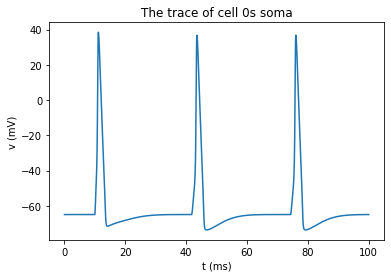

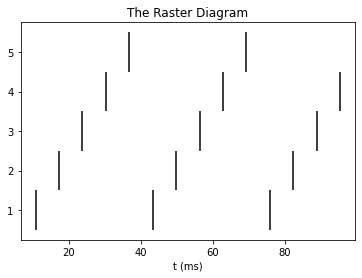

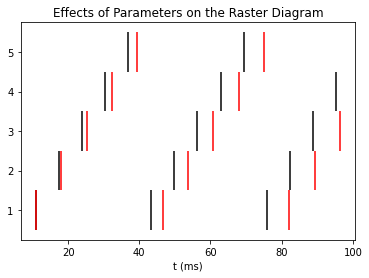

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ring = Ring(N=5)
shape_window = h.PlotShape(True)
shape_window.show(0)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)


plt.plot(t, ring.cells[0].soma_v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.title('The trace of cell 0s soma')
plt.show()


plt.figure()
for i, cell in enumerate(ring.cells):
    plt.vlines(cell.spike_times, i + 0.5, i + 1.5)
plt.xlabel('t (ms)')
#plt.ylabel('v (mV)')
plt.title('The Raster Diagram')
plt.show()

plt.figure()
for syn_w, color in [(0.01, 'black'), (0.005, 'red')]:
    ring = Ring(N=5, syn_w=syn_w)
    h.finitialize(-65 * mV)
    h.continuerun(100 * ms)
    for i, cell in enumerate(ring.cells):
        plt.vlines(cell.spike_times, i + 0.5, i + 1.5, color=color)
plt.xlabel('t (ms)')
#plt.ylabel('v (mV)')
plt.title('Effects of Parameters on the Raster Diagram')
plt.show()

Parallel communication in NEURON


The code below is very familiar to the last one.

The conceptually new pieces are:

pc.set_maxstep(10 * ms) -- sets an upper bound on how far MPI can simulate without communicating, here a simulated 10 ms. This must be called before attempting a parallel simulation.

pc.psolve(100 * ms) -- a parallel version of h.continuerun, but does not support updating NEURON graphics during the simulation.

pc.gid_exists -- only the process that owns the specified cell should make the plot.

pc.gid2cell -- lookup a cell by gid

pc.barrier() -- wait until all processes reach this point; used to make sure processes don't shut down before the graph is closed

In [ ]:
%%writefile ring1.py

from neuron import h, gui
from neuron.units import ms, mV
h.load_file('stdrun.hoc')

"""cell starts"""
#hocobj_call 
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        
        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        self._ncs = []
        
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c


"""
cell end
"""
class BallAndStick(Cell):
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms
"""
BallAndStick end
"""

from neuron import h
#from ballandstick import BallAndStick

### MPI must be initialized before we create a ParallelContext object
h.nrnmpi_init()
pc = h.ParallelContext()

class Ring1:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """ 
        self._N = N
        self.set_gids()                   ### assign gids to processors
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(r)             ### changed to use self._N instead of passing in N
        self._connect_cells()
        ### the 0th cell only exists on one process... that's the only one that gets a netstim
        if pc.gid_exists(0):
            self._netstim = h.NetStim()
            self._netstim.number = 1
            self._netstim.start = stim_t
            self._nc = h.NetCon(self._netstim, pc.gid2cell(0).syn)   ### grab cell with gid==0 wherever it exists
            self._nc.delay = stim_delay
            self._nc.weight[0] = stim_w
    
    def set_gids(self):
        """Set the gidlist on this host."""
        #### Round-robin counting.
        #### Each host has an id from 0 to pc.nhost() - 1.
        self.gidlist = list(range(pc.id(), self._N, pc.nhost()))
        for gid in self.gidlist:
            pc.set_gid2node(gid, pc.id())
    
    def _create_cells(self, r):
        self.cells = []
        for i in self.gidlist:    ### only create the cells that exist on this host
            theta = i * 2 * h.PI / self._N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
        ### associate the cell with this host and gid
        for cell in self.cells:
            pc.cell(cell._gid, cell._spike_detector)

    def _connect_cells(self):
        ### this method is different because we now must use ids instead of objects
        for target in self.cells:
            source_gid = (target._gid - 1 + self._N) % self._N
            nc = pc.gid_connect(source_gid, target.syn)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            target._ncs.append(nc)




from neuron.units import ms, mV
import matplotlib.pyplot as plt
#import ring
#from ring import Ring

cell_to_plot = 0

ring = Ring1()

pc = h.ParallelContext()
pc.set_maxstep(10 * ms)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
pc.psolve(100 * ms)

if pc.gid_exists(cell_to_plot):
    plt.figure()
    plt.plot(t, pc.gid2cell(cell_to_plot).soma_v)
    plt.show()

pc.barrier()
pc.done()
#h.quit()

Writing ring1.py


In [ ]:
!mpiexec --allow-run-as-root -quiet -n 4 python ring1.py

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
numprocs=4
Figure(640x480)
